In [3]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### This relates to plotting datetime values with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
path = r'/Alcohol_Sales.csv'

In [8]:
df = pd.read_csv(path, index_col=0,parse_dates=True)

In [10]:
### Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

## Inspect Data

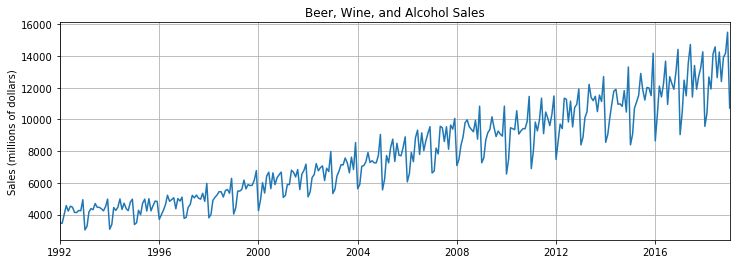

In [14]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare Data 

In [54]:
### Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

### Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [55]:
from sklearn.preprocessing import MinMaxScaler

### Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [56]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

##### Split training data into batches

In [57]:
### Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

### Define a window size
window_size = 12

### Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

### Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  ### this should equal 325-12-12

253

## Modelling LSTM 

In [58]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1): ### hidden neurons = 100 
        super().__init__()
        self.hidden_size = hidden_size
        
        ### Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        ### Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        ### Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  ### we only want the last value

##### Instantiate the model, define loss and optimization functions

In [29]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train Model

In [59]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

KeyboardInterrupt: 

## Model Evaluation 

In [60]:
future = 12

### Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

### Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

##### Invert the normalization

In [61]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[ 9892.39935088],
       [ 9867.16268384],
       [10456.23613477],
       [11107.24876904],
       [12076.28955555],
       [13011.65026665],
       [ 9225.44844246],
       [10457.20711136],
       [ 9655.58351123],
       [ 9914.00686204],
       [10752.67696643],
       [10946.29664493],
       [ 8520.66052222],
       [ 9059.65418953],
       [10193.68924928],
       [10798.32998252],
       [ 8984.55879682],
       [ 9095.88339007],
       [ 9386.14598227],
       [ 9674.92834616],
       [10567.79773903],
       [ 9252.46067721],
       [ 9214.04794258],
       [ 9579.18752837],
       [ 9176.51532686],
       [ 9401.28793263],
       [ 9648.75136232],
       [ 9894.20778024],
       [10410.11998129],
       [ 9677.66911578],
       [10160.46383619],
       [ 9217.68075436],
       [ 8934.07869101],
       [ 9491.00115108],
       [ 9297.11895329],
       [ 9200.75575829]])

## Plot the results

In [34]:
### Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

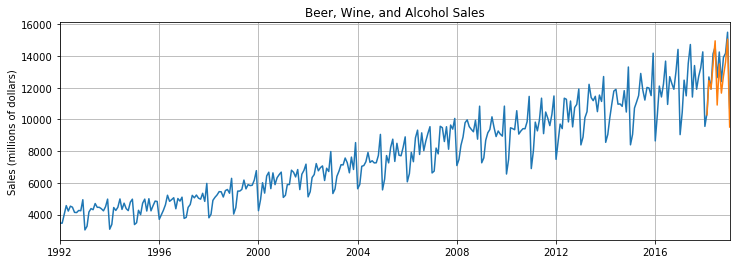

In [35]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

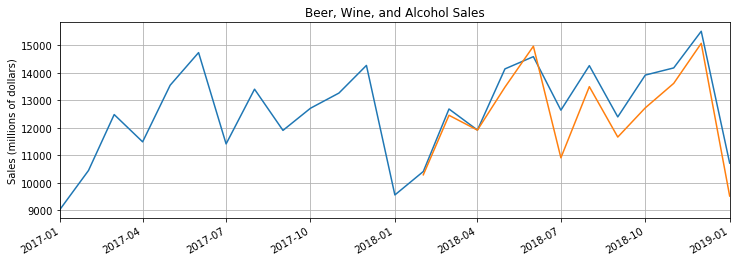

In [37]:
### Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

### Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

## Predict into the future
To train the model to predict into the unknown future we need to train it to all the avialable data 

In [62]:
epochs = 100

### set model to back to training mode
model.train()

### feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    ### train on the full set of sequences
    for seq, y_train in all_data:  
        
        ### reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    ### print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.23651174
Epoch:  2 Loss: 0.12679262
Epoch:  3 Loss: 0.39237806
Epoch:  4 Loss: 0.09898587
Epoch:  5 Loss: 0.02885847
Epoch:  6 Loss: 0.00281625
Epoch:  7 Loss: 0.25804633
Epoch:  8 Loss: 0.00293751
Epoch:  9 Loss: 0.05472657
Epoch: 10 Loss: 0.03503150
Epoch: 11 Loss: 0.03777742
Epoch: 12 Loss: 0.02592985
Epoch: 13 Loss: 0.05435950
Epoch: 14 Loss: 0.01439732
Epoch: 15 Loss: 0.01214418
Epoch: 16 Loss: 0.00141846
Epoch: 17 Loss: 0.00000844
Epoch: 18 Loss: 0.00420256
Epoch: 19 Loss: 0.03557695
Epoch: 20 Loss: 0.00038317
Epoch: 21 Loss: 0.00684595
Epoch: 22 Loss: 0.00726147
Epoch: 23 Loss: 0.00146669
Epoch: 24 Loss: 0.05011344
Epoch: 25 Loss: 0.01255061
Epoch: 26 Loss: 0.00684531
Epoch: 27 Loss: 0.00654288
Epoch: 28 Loss: 0.01016073
Epoch: 29 Loss: 0.00923005
Epoch: 30 Loss: 0.01167108
Epoch: 31 Loss: 0.01528641
Epoch: 32 Loss: 0.01845000
Epoch: 33 Loss: 0.03986190
Epoch: 34 Loss: 0.02089648
Epoch: 35 Loss: 0.17200051
Epoch: 36 Loss: 0.00157492
Epoch: 37 Loss: 0.00562144
E

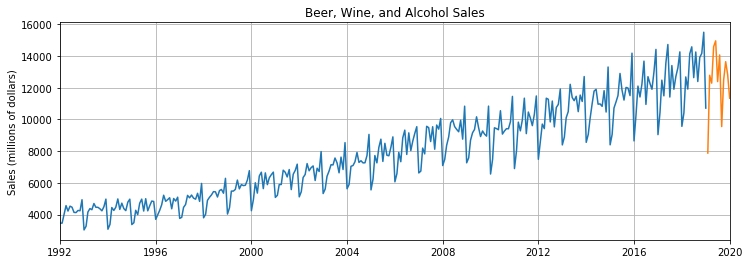

In [65]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

### Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

### PLOT THE RESULT
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

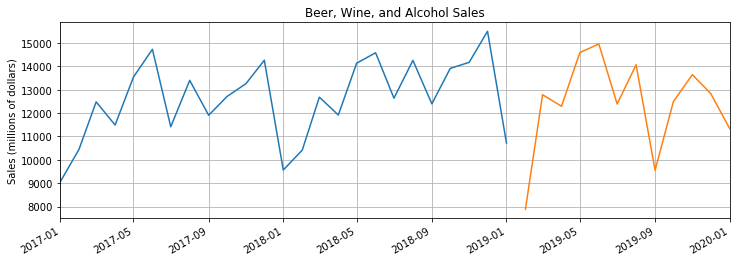

In [66]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()